In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from statsmodels.distributions.empirical_distribution import ECDF
from scipy.stats import gaussian_kde, mannwhitneyu
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [3]:
# rpy2 (for AdhereR)
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri

In [4]:
# -------------------------
# Load dataset – uses AdhereR's med.events
# -------------------------
pandas2ri.activate()
robjects.r('library(AdhereR)')
med_events_r = robjects.r('med.events')
med_events = pandas2ri.rpy2py(med_events_r)

In [5]:
ExamplePats = med_events.copy()
tidy = ExamplePats.copy()
tidy.columns = ["pnr", "eksd", "perday", "ATC", "dur_original"]
tidy['eksd'] = pd.to_datetime(tidy['eksd'], format='%m/%d/%Y')

In [6]:
def See_kmeans(arg1):
    """
    Existing clustering procedure with K-means:
    - Filters the data for the given ATC,
    - Samples random consecutive prescription pairs,
    - Computes event intervals and its ECDF,
    - Uses gaussian_kde over the log-transformed intervals,
    - Clusters the ECDF x-values using K-means (with silhouette-based optimal k),
    - Computes cluster statistics and assigns a cluster-based median for each patient,
    - Returns the final merged dataframe and clustering details.
    """
    # Filter rows where ATC equals arg1
    C09CA01 = tidy[tidy['ATC'] == arg1].copy()

    # Take a copy (for later merging)
    drug_see_p0 = C09CA01.copy()

    # Sort by pnr and eksd; compute previous prescription date per patient
    drug_see_p1 = C09CA01.sort_values(['pnr', 'eksd']).copy()
    drug_see_p1['prev_eksd'] = drug_see_p1.groupby('pnr')['eksd'].shift(1)
    drug_see_p1 = drug_see_p1.dropna(subset=['prev_eksd']).copy()

    # For each patient, randomly sample one row (with a fixed seed)
    drug_see_p1 = (drug_see_p1
                   .groupby('pnr', group_keys=False)
                   .apply(lambda x: x.sample(1, random_state=1234))
                   .reset_index(drop=True))
    # Retain key columns
    drug_see_p1 = drug_see_p1[['pnr', 'eksd', 'prev_eksd']]

    # Compute event interval (in days)
    drug_see_p1['event.interval'] = (drug_see_p1['eksd'] - drug_see_p1['prev_eksd']).dt.days.astype(float)
    
    # Compute the ECDF function using statsmodels
    ecdf_func = ECDF(drug_see_p1['event.interval'].values)

    # Use sorted event intervals as x-values
    x_vals = np.sort(drug_see_p1['event.interval'].values)
    y_vals = ecdf_func(x_vals)

    df_ecdf = pd.DataFrame({'x': x_vals, 'y': y_vals})
    
    # Retain the lower 80% of the ECDF (i.e. where cumulative probability <= 0.8)
    df_ecdf_80 = df_ecdf[df_ecdf['y'] <= 0.8]
    ni = df_ecdf_80['x'].max()
    
    # Subset data for event intervals up to the 80th percentile
    drug_see_p2 = drug_see_p1[drug_see_p1['event.interval'] <= ni].copy()
    
    # --- Density estimation on log(event.interval) ---
    log_intervals = np.log(drug_see_p2['event.interval'])
    kde = gaussian_kde(log_intervals)
    x_grid = np.linspace(log_intervals.min(), log_intervals.max(), 100)
    y_kde = kde(x_grid)
    
    # Prepare KDE points for clustering.
    kde_df = pd.DataFrame({'x': x_grid, 'y': y_kde})
    scaler = StandardScaler()
    kde_scaled = scaler.fit_transform(kde_df)

    # --- Determine optimal number of clusters via silhouette analysis for KMeans ---
    silhouette_scores = {}
    for k in range(2, min(11, len(kde_scaled))):
        km = KMeans(n_clusters=k, random_state=1234)
        labels = km.fit_predict(kde_scaled)
        score = silhouette_score(kde_scaled, labels)
        silhouette_scores[k] = score
    if silhouette_scores:
        optimal_k = max(silhouette_scores, key=silhouette_scores.get)
    else:
        optimal_k = 1

    # Plot silhouette scores
    plt.figure(figsize=(8, 5))
    plt.plot(list(silhouette_scores.keys()), list(silhouette_scores.values()), marker='o')
    plt.title("KMeans Silhouette Analysis")
    plt.xlabel("Number of clusters")
    plt.ylabel("Silhouette Score")
    plt.show()
    
    # --- K-means clustering on the ECDF x values (event intervals) ---
    km_ecdf = KMeans(n_clusters=optimal_k, random_state=1234)
    df_ecdf['cluster'] = km_ecdf.fit_predict(df_ecdf[['x']])
    
    # For each cluster, compute the min, max, and median on the log scale then exponentiate
    cluster_stats = (df_ecdf.groupby('cluster')['x']
                     .agg(min_log=lambda x: np.log(x).min(),
                          max_log=lambda x: np.log(x).max(),
                          median_log=lambda x: np.log(x).median())
                     .reset_index())
    cluster_stats['Minimum'] = np.exp(cluster_stats['min_log'])
    cluster_stats['Maximum'] = np.exp(cluster_stats['max_log'])
    cluster_stats['Median'] = np.exp(cluster_stats['median_log'])
    cluster_stats = cluster_stats[cluster_stats['Median'] > 0]
    
    # --- Cross join drug_see_p1 with cluster_stats ---
    drug_see_p1['_key'] = 1
    cluster_stats['_key'] = 1
    cross_df = pd.merge(drug_see_p1, cluster_stats, on='_key').drop('_key', axis=1)
    
    # For each row, assign Final_cluster if the event interval falls within the cluster’s [Minimum, Maximum]
    cross_df['Final_cluster'] = cross_df.apply(
        lambda row: row['cluster'] if (row['event.interval'] >= row['Minimum'] and row['event.interval'] <= row['Maximum'])
        else np.nan, axis=1)
    results = cross_df.dropna(subset=['Final_cluster']).copy()
    results = results[['pnr', 'Median', 'Final_cluster']]

    # Determine the most common cluster and set a default median
    most_common_cluster = results['Final_cluster'].value_counts().idxmax()
    default_median = cluster_stats.loc[cluster_stats['cluster'] == most_common_cluster, 'Median'].values[0]

    # Merge cluster assignments back into drug_see_p1 and compute the difference to the median
    drug_see_p1 = pd.merge(drug_see_p1, results, on='pnr', how='left')
    drug_see_p1['Median'] = drug_see_p1['Median'].fillna(default_median)
    drug_see_p1['Cluster'] = drug_see_p1['Final_cluster'].fillna(0)
    drug_see_p1['test'] = (drug_see_p1['event.interval'] - drug_see_p1['Median']).round(1)
    
    drug_see_p3 = drug_see_p1[['pnr', 'Median', 'Cluster', 'test']]
    
    # Finally, merge these assignments back into the original filtered data (drug_see_p0)
    final_df = pd.merge(drug_see_p0, drug_see_p3, on='pnr', how='left')
    final_df['Median'] = final_df['Median'].fillna(default_median)
    final_df['Cluster'] = final_df['Cluster'].fillna(0)

    # Return both the final merged dataframe and the clustering details (with the 'test' differences)
    return final_df, drug_see_p1

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9476\1167724479.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(1, random_state=1234))


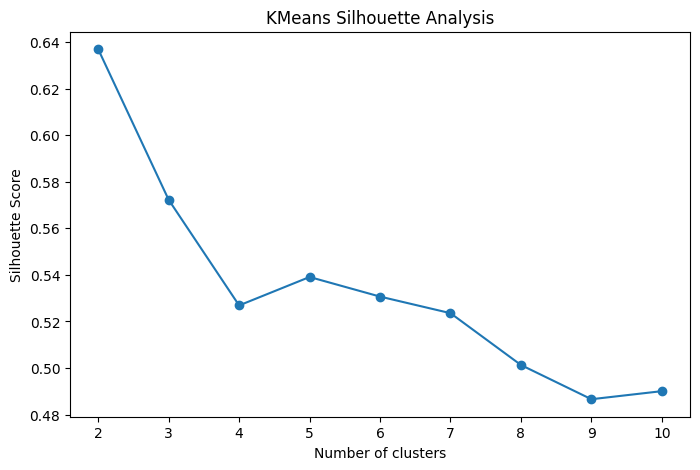

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9476\1167724479.py:26: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(1, random_state=1234))


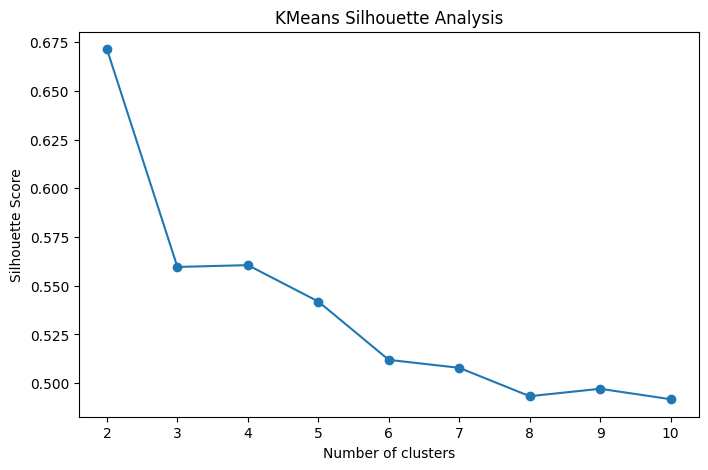

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9476\4250593470.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(1, random_state=1234))


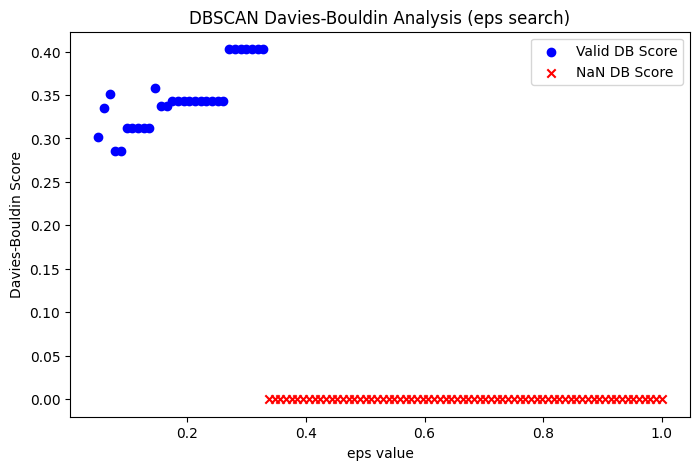

db_scores (2D list): [[0.05, 0.30211090716287126], [0.0595959595959596, 0.3351821748204701], [0.0691919191919192, 0.3510393787189037], [0.0787878787878788, 0.2854019941747381], [0.08838383838383838, 0.2854019941747381], [0.09797979797979797, 0.3118481709641419], [0.10757575757575757, 0.3118481709641419], [0.11717171717171716, 0.3118481709641419], [0.12676767676767675, 0.3118481709641419], [0.13636363636363635, 0.3118481709641419], [0.14595959595959596, 0.35824828275898857], [0.15555555555555556, 0.33762833038796153], [0.16515151515151516, 0.33762833038796153], [0.17474747474747476, 0.3426481751640748], [0.1843434343434343, 0.3426481751640748], [0.1939393939393939, 0.3426481751640748], [0.2035353535353535, 0.3426481751640748], [0.21313131313131312, 0.3426481751640748], [0.22272727272727272, 0.3426481751640748], [0.23232323232323232, 0.3426481751640748], [0.24191919191919192, 0.3426481751640748], [0.2515151515151515, 0.3426481751640748], [0.26111111111111107, 0.3426481751640748], [0.2707

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9476\4250593470.py:19: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(1, random_state=1234))


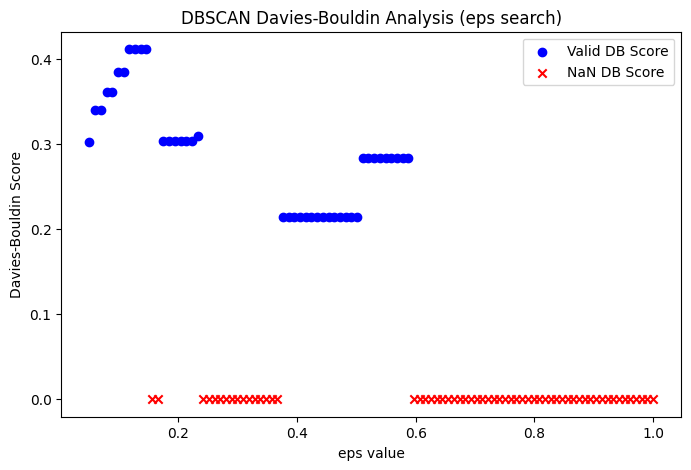

db_scores (2D list): [[0.05, 0.3024857161446837], [0.0595959595959596, 0.3395461236010955], [0.0691919191919192, 0.3395461236010955], [0.0787878787878788, 0.3604229499125424], [0.08838383838383838, 0.3604229499125424], [0.09797979797979797, 0.3836619889806634], [0.10757575757575757, 0.3836619889806634], [0.11717171717171716, 0.41096617509795563], [0.12676767676767675, 0.41096617509795563], [0.13636363636363635, 0.41096617509795563], [0.14595959595959596, 0.41096617509795563], [0.15555555555555556, nan], [0.16515151515151516, nan], [0.17474747474747476, 0.30357475399822775], [0.1843434343434343, 0.30357475399822775], [0.1939393939393939, 0.30357475399822775], [0.2035353535353535, 0.30357475399822775], [0.21313131313131312, 0.30357475399822775], [0.22272727272727272, 0.30357475399822775], [0.23232323232323232, 0.3092105600709595], [0.24191919191919192, nan], [0.2515151515151515, nan], [0.26111111111111107, nan], [0.2707070707070707, nan], [0.2803030303030303, nan], [0.2898989898989899, n

In [7]:
def See_dbscan(arg1, eps_range=(0.05, 1.0), num_eps=100, min_samples=3):
    """
    Clustering using DBSCAN with Davies-Bouldin-based optimal eps.
    The function follows steps very similar to See_kmeans up until the clustering stage.
    Instead of using KMeans on the ECDF x values, it scales the x data and searches over a
    range of eps values to select the eps that yields the lowest DB score (computed on non-noise points).
    The chosen DBSCAN clustering is then used to compute cluster summary statistics and to assign each patient a median.
    """
    # Filter rows where ATC equals arg1
    C09CA01 = tidy[tidy['ATC'] == arg1].copy()
    drug_see_p0 = C09CA01.copy()

    # Compute previous prescription date per patient and select one random pair per patient
    drug_see_p1 = C09CA01.sort_values(['pnr', 'eksd']).copy()
    drug_see_p1['prev_eksd'] = drug_see_p1.groupby('pnr')['eksd'].shift(1)
    drug_see_p1 = drug_see_p1.dropna(subset=['prev_eksd']).copy()
    drug_see_p1 = (drug_see_p1
                   .groupby('pnr', group_keys=False)
                   .apply(lambda x: x.sample(1, random_state=1234))
                   .reset_index(drop=True))
    drug_see_p1 = drug_see_p1[['pnr', 'eksd', 'prev_eksd']]
    drug_see_p1['event.interval'] = (drug_see_p1['eksd'] - drug_see_p1['prev_eksd']).dt.days.astype(float)

    # Compute the ECDF on event intervals
    ecdf_func = ECDF(drug_see_p1['event.interval'].values)
    x_vals = np.sort(drug_see_p1['event.interval'].values)
    y_vals = ecdf_func(x_vals)
    df_ecdf = pd.DataFrame({'x': x_vals, 'y': y_vals})
    
    # Limit analysis to the lower 80% of the ECDF
    df_ecdf_80 = df_ecdf[df_ecdf['y'] <= 0.8]
    ni = df_ecdf_80['x'].max()
    drug_see_p2 = drug_see_p1[drug_see_p1['event.interval'] <= ni].copy()

    # --- Density estimation on log(event.interval) ---
    log_intervals = np.log(drug_see_p2['event.interval'])
    kde = gaussian_kde(log_intervals)
    x_grid = np.linspace(log_intervals.min(), log_intervals.max(), 100)
    y_kde = kde(x_grid)
    kde_df = pd.DataFrame({'x': x_grid, 'y': y_kde})
    
    # --- DBSCAN clustering on ECDF x values ---
    # Scale the x values
    scaler = StandardScaler()
    df_ecdf_scaled = scaler.fit_transform(df_ecdf[['x']])
    
    # Search for an optimal eps by iterating over a range of eps values and computing Davies-Bouldin scores.
    # Always record an entry so that the plot always has num_eps points.
    eps_values = np.linspace(eps_range[0], eps_range[1], num_eps)
    db_scores = []  # This will store entries as [eps, score]
    for eps in eps_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
        labels = dbscan.fit_predict(df_ecdf_scaled)
        labels_valid = labels[labels != -1]
        if len(np.unique(labels_valid)) >= 2:
            mask = labels != -1
            score = davies_bouldin_score(df_ecdf_scaled[mask], labels[mask])
        else:
            score = np.nan  # Mark as invalid if insufficient clusters
        db_scores.append([eps, score])
    
    # Select best_eps from non-NaN scores
    valid_scores = [entry for entry in db_scores if not np.isnan(entry[1])]
    if valid_scores:
        best_eps = min(valid_scores, key=lambda tup: tup[1])[0]
    else:
        best_eps = eps_range[0]  # default if no valid eps found

    eps_list = [item[0] for item in db_scores]
    score_list = [item[1] for item in db_scores]

    # Separate valid and invalid points
    valid_x = [eps for eps, sc in db_scores if not np.isnan(sc)]
    valid_y = [sc for eps, sc in db_scores if not np.isnan(sc)]
    invalid_x = [eps for eps, sc in db_scores if np.isnan(sc)]
    invalid_y = [0 for eps, sc in db_scores if np.isnan(sc)]  # or you can keep them as np.nan

    plt.figure(figsize=(8, 5))
    # Plot valid points
    plt.scatter(valid_x, valid_y, color='blue', marker='o', label='Valid DB Score')
    # Plot invalid points
    plt.scatter(invalid_x, invalid_y, color='red', marker='x', label='NaN DB Score')

    plt.title("DBSCAN Davies-Bouldin Analysis (eps search)")
    plt.xlabel("eps value")
    plt.ylabel("Davies-Bouldin Score")
    plt.legend()
    plt.show()

    print("db_scores (2D list):", db_scores)

    # Run DBSCAN with the best eps value
    dbscan_final = DBSCAN(eps=best_eps, min_samples=min_samples, n_jobs=-1)
    df_ecdf['cluster'] = dbscan_final.fit_predict(df_ecdf_scaled)
    
    # Compute cluster summary statistics on the raw x scale for non-noise clusters
    cluster_stats = (df_ecdf[df_ecdf['cluster'] != -1].groupby('cluster')['x']
                     .agg(min_log=lambda x: np.log(x).min(),
                          max_log=lambda x: np.log(x).max(),
                          median_log=lambda x: np.log(x).median())
                     .reset_index())
    cluster_stats['Minimum'] = np.exp(cluster_stats['min_log'])
    cluster_stats['Maximum'] = np.exp(cluster_stats['max_log'])
    cluster_stats['Median'] = np.exp(cluster_stats['median_log'])
    
    # If no clusters were identified (i.e. all noise), assign default values
    if cluster_stats.empty:
        default_median = np.median(drug_see_p1['event.interval'])
        drug_see_p1['Cluster'] = 0
        drug_see_p1['Median'] = default_median
    else:
        # Cross join drug_see_p1 with cluster_stats using a temporary key
        drug_see_p1['_key'] = 1
        cluster_stats['_key'] = 1
        cross_df = pd.merge(drug_see_p1, cluster_stats, on='_key').drop('_key', axis=1)

        # For each row, assign Final_cluster if the event interval falls within the cluster’s [Minimum, Maximum]
        cross_df['Final_cluster'] = cross_df.apply(
            lambda row: row['cluster'] if (row['event.interval'] >= row['Minimum'] and row['event.interval'] <= row['Maximum'])
            else np.nan, axis=1)
        results = cross_df.dropna(subset=['Final_cluster']).copy()
        results = results[['pnr', 'Median', 'Final_cluster']]
        
        # Determine the most common cluster and set a default median
        most_common_cluster = results['Final_cluster'].value_counts().idxmax()
        default_median = cluster_stats.loc[cluster_stats['cluster'] == most_common_cluster, 'Median'].values[0]

        # Merge cluster assignments back into drug_see_p1
        drug_see_p1 = pd.merge(drug_see_p1, results, on='pnr', how='left')
        drug_see_p1['Median'] = drug_see_p1['Median'].fillna(default_median)
        drug_see_p1['Cluster'] = drug_see_p1['Final_cluster'].fillna(0)
    
    # Compute the difference between the event interval and the assigned median
    drug_see_p1['test'] = (drug_see_p1['event.interval'] - drug_see_p1['Median']).round(1)
    drug_see_p3 = drug_see_p1[['pnr', 'Median', 'Cluster', 'test']]
    
    # Merge these assignments back into the original filtered data
    final_df = pd.merge(drug_see_p0, drug_see_p3, on='pnr', how='left')
    final_df['Median'] = final_df['Median'].fillna(default_median)
    final_df['Cluster'] = final_df['Cluster'].fillna(0)

    return final_df, drug_see_p1

# -------------------------------------------------------------------------
# Example usage:
# Generate medA and medB clustering results using KMeans and DBSCAN
# -------------------------------------------------------------------------
medA_final_km, medA_clust_km = See_kmeans("medA")
medB_final_km, medB_clust_km = See_kmeans("medB")

medA_final_db, medA_clust_db = See_dbscan("medA")
medB_final_db, medB_clust_db = See_dbscan("medB")

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9476\3111911576.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='method', y='median_value', data=combined,


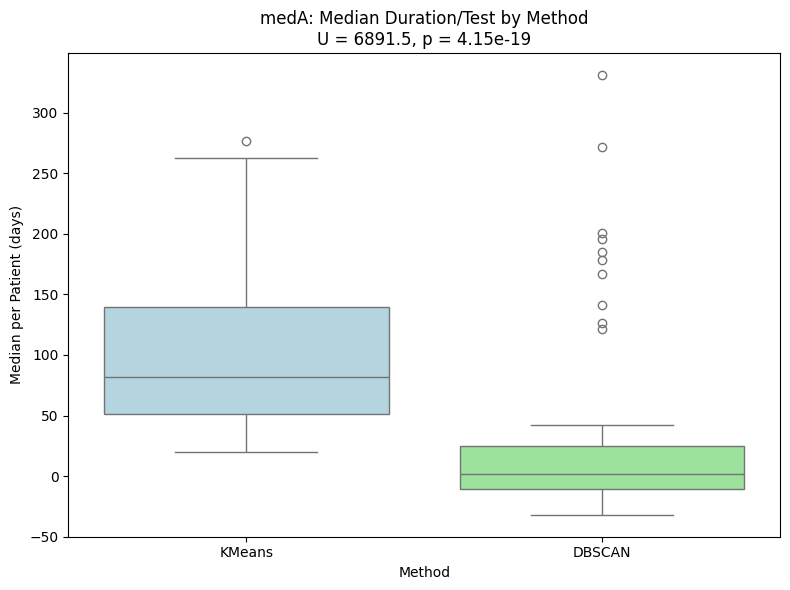

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9476\3111911576.py:60: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='method', y='median_value', data=combined,


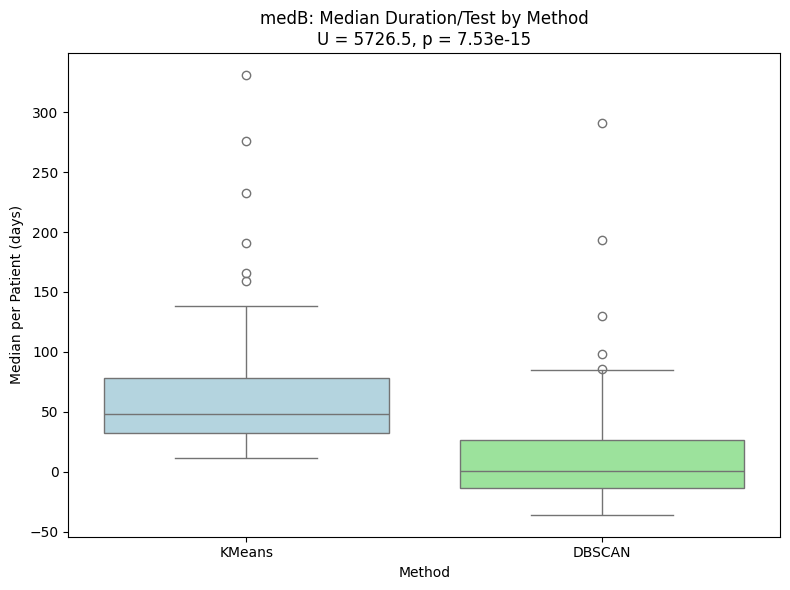

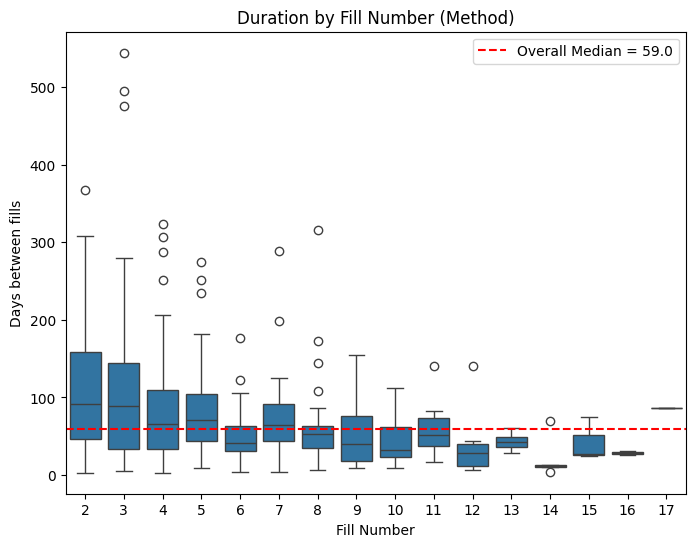

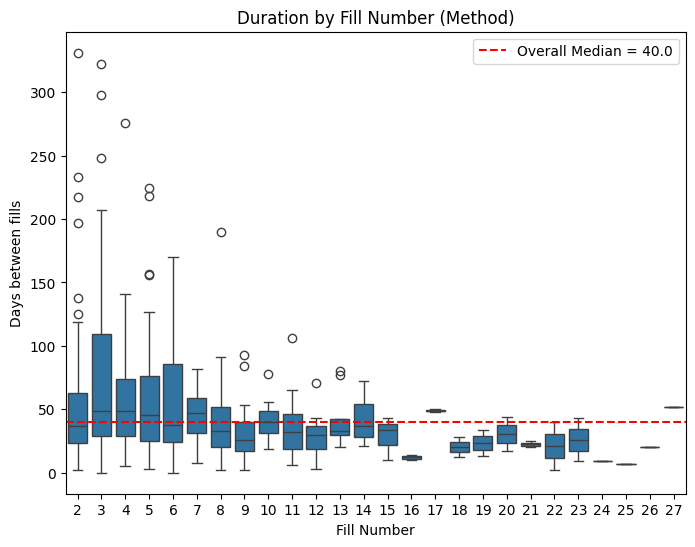

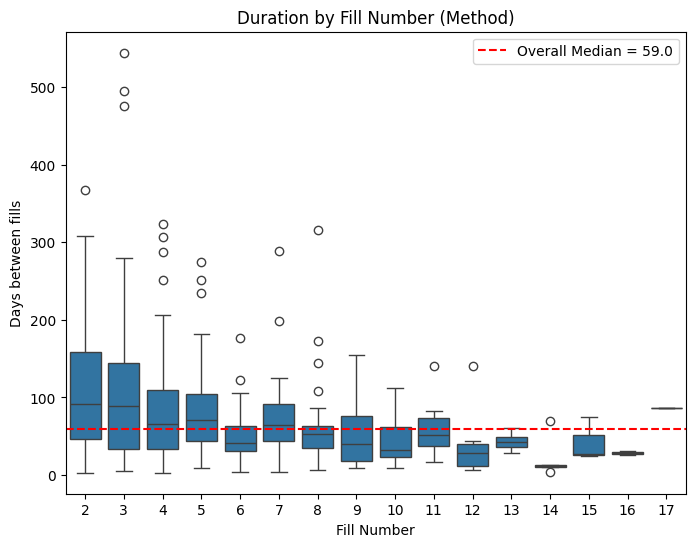

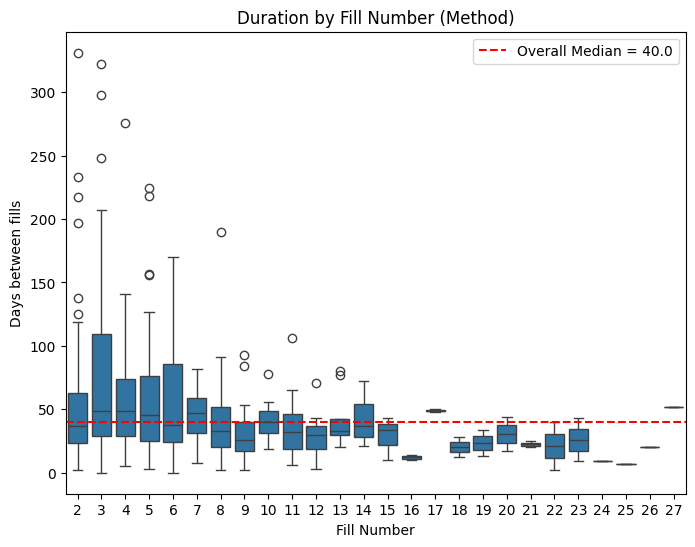

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9476\3111911576.py:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='method', y='median_value', data=combined_fill_medians,


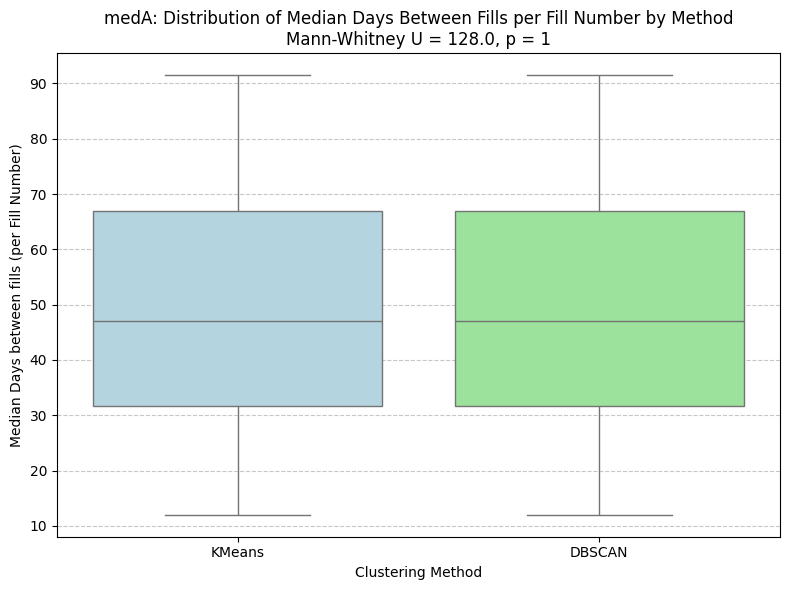

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_9476\3111911576.py:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='method', y='median_value', data=combined_fill_medians,


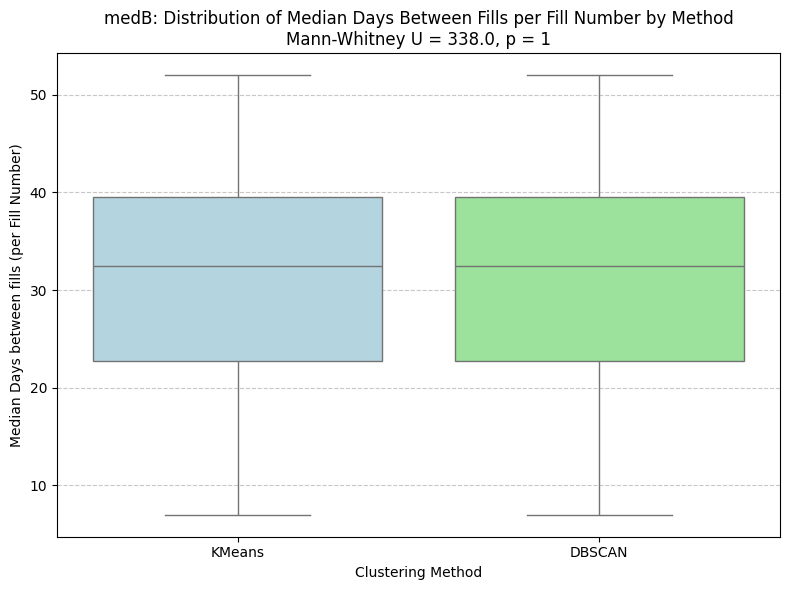

In [8]:
def see_assumption(df, method_name="Method"):
    df_sorted = df.sort_values(['pnr', 'eksd']).copy()
    df_sorted['prev_eksd'] = df_sorted.groupby('pnr')['eksd'].shift(1)
    df_sorted['p_number'] = df_sorted.groupby('pnr').cumcount() + 1
    df2 = df_sorted[df_sorted['p_number'] >= 2].copy()
    df2['Duration'] = (df2['eksd'] - df2['prev_eksd']).dt.days

    plt.figure(figsize=(8,6))
    sns.boxplot(x='p_number', y='Duration', data=df2)
    overall_median = df2['Duration'].median()
    plt.axhline(overall_median, color='red', linestyle='--',
                label=f'Overall Median = {overall_median:.1f}')
    plt.title(f"Duration by Fill Number ({method_name})")
    plt.xlabel("Fill Number")
    plt.ylabel("Days between fills")
    plt.legend()
    plt.show()

def see_assumption_medians(df_kmeans):
    """
    Given the KMeans cluster_details_km DataFrame with columns
    ['pnr', 'eksd', …], compute each patient’s median refill Duration.
    """
    df_sorted = df_kmeans.sort_values(['pnr', 'eksd']).copy()
    df_sorted['prev_eksd'] = df_sorted.groupby('pnr')['eksd'].shift(1)
    df2 = df_sorted.dropna(subset=['prev_eksd']).copy()
    df2['Duration'] = (df2['eksd'] - df2['prev_eksd']).dt.days
    # Median duration per patient
    medians = df2.groupby('pnr')['Duration'].median().reset_index()
    medians.rename(columns={'Duration': 'median_value'}, inplace=True)
    medians['method'] = 'KMeans'
    return medians

def see_assumption_dbscan_medians(df_dbscan):
    """
    Given the DBSCAN cluster_details_dbscan DataFrame with columns
    ['pnr', 'test', …], compute each patient’s median deviation from median.
    """
    df = df_dbscan[['pnr', 'test']].dropna(subset=['test']).copy()
    # Median test per patient
    medians = df.groupby('pnr')['test'].median().reset_index()
    medians.rename(columns={'test': 'median_value'}, inplace=True)
    medians['method'] = 'DBSCAN'
    return medians

def compare_medians_distributions(df_km, df_db, med_name="Medication"):
    # extract per-patient medians
    km = see_assumption_medians(df_km)
    km['method'] = 'KMeans'
    db = see_assumption_dbscan_medians(df_db)
    db['method'] = 'DBSCAN'

    combined = pd.concat([km, db], ignore_index=True)

    # statistical test
    stat, p = mannwhitneyu(km['median_value'], db['median_value'], alternative='two-sided')
    annotation = f"U = {stat:.1f}, p = {p:.3g}"

    plt.figure(figsize=(8,6))
    sns.boxplot(x='method', y='median_value', data=combined,
                palette={"KMeans":"lightblue","DBSCAN":"lightgreen"})
    plt.title(f"{med_name}: Median Duration/Test by Method\n{annotation}")
    plt.xlabel("Method")
    plt.ylabel("Median per Patient (days)")
    plt.tight_layout()
    plt.show()

compare_medians_distributions(medA_final_km, medA_clust_db, med_name="medA")
compare_medians_distributions(medB_final_km, medB_clust_db, med_name="medB")

see_assumption(medA_final_km)
see_assumption(medB_final_km)
see_assumption(medA_final_db)
see_assumption(medB_final_db)

def get_fill_number_medians(df, method_type="KMeans"):
    """
    Calculates the median 'Days between fills' for each fill number.

    Args:
        df (pd.DataFrame): The final merged DataFrame from See_kmeans or See_dbscan.
        method_type (str): 'KMeans' or 'DBSCAN' to label the method in the output.

    Returns:
        pd.DataFrame: A DataFrame with 'p_number', 'median_value', and 'method'.
    """
    df_sorted = df.sort_values(['pnr', 'eksd']).copy()
    df_sorted['prev_eksd'] = df_sorted.groupby('pnr')['eksd'].shift(1)
    df_sorted['p_number'] = df_sorted.groupby('pnr').cumcount() + 1 # Fill number

    # Filter for fill numbers >= 2 as 'Duration' requires a 'prev_eksd'
    df_with_duration = df_sorted[df_sorted['p_number'] >= 2].copy()
    df_with_duration['Duration'] = (df_with_duration['eksd'] - df_with_duration['prev_eksd']).dt.days
    
    # Group by fill number and get the median duration for that fill number
    medians_by_fill = df_with_duration.groupby('p_number')['Duration'].median().reset_index()
    medians_by_fill.rename(columns={'Duration': 'median_value'}, inplace=True)
    
    medians_by_fill['method'] = method_type
    return medians_by_fill

def compare_fill_number_medians_distributions(df_km_final, df_db_final, med_name="Medication"):
    """
    Compares the distributions of *medians per fill number* between KMeans and DBSCAN
    clustering results using a single box plot and Mann-Whitney U test.

    Args:
        df_km_final (pd.DataFrame): The final merged DataFrame from See_kmeans.
        df_db_final (pd.DataFrame): The final merged DataFrame from See_dbscan.
        med_name (str): The name of the medication for plot titles.
    """
    # Get medians for each fill number for KMeans
    km_fill_medians = get_fill_number_medians(df_km_final, method_type="KMeans")

    # Get medians for each fill number for DBSCAN
    db_fill_medians = get_fill_number_medians(df_db_final, method_type="DBSCAN")

    # Concatenate the results
    combined_fill_medians = pd.concat([km_fill_medians, db_fill_medians], ignore_index=True)

    # Prepare data for Mann-Whitney U test (comparing the collection of medians from each method)
    km_data_for_test = combined_fill_medians[combined_fill_medians['method'] == 'KMeans']['median_value']
    db_data_for_test = combined_fill_medians[combined_fill_medians['method'] == 'DBSCAN']['median_value']

    # Perform Mann-Whitney U test
    if len(km_data_for_test) > 1 and len(db_data_for_test) > 1:
        stat, p = mannwhitneyu(km_data_for_test, db_data_for_test, alternative='two-sided')
        annotation = f"Mann-Whitney U = {stat:.1f}, p = {p:.3g}"
    else:
        annotation = "Mann-Whitney U Test not applicable (insufficient data points for comparison)."

    plt.figure(figsize=(8, 6)) # Adjusted figure size for a single plot

    # Single Box plot comparing the distributions of medians per fill number
    sns.boxplot(x='method', y='median_value', data=combined_fill_medians,
                palette={"KMeans":"lightblue","DBSCAN":"lightgreen"})
    
    plt.title(f"{med_name}: Distribution of Median Days Between Fills per Fill Number by Method\n{annotation}")
    plt.xlabel("Clustering Method")
    plt.ylabel("Median Days between fills (per Fill Number)")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Example usage with the generated dummy data
compare_fill_number_medians_distributions(medA_final_km, medA_final_db, med_name="medA")
compare_fill_number_medians_distributions(medB_final_km, medB_final_db, med_name="medB")